In [4]:
import pandas as pd
import numpy as np
import json
 
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [104]:
with open('Client_data.json') as f:
    json_data = json.load(f)


In [105]:
for i in json_data[:2]:
    X = pd.DataFrame.from_dict(i)
    X.head()

In [107]:
X.head()

,_index,_type,_id,_score,_source
company,complaint-public-v2,complaint,3229299,0.0,JPMORGAN CHASE & CO.
company_public_response,complaint-public-v2,complaint,3229299,0.0,None
company_response,complaint-public-v2,complaint,3229299,0.0,Closed with explanation
complaint_id,complaint-public-v2,complaint,3229299,0.0,3229299
complaint_what_happened,complaint-public-v2,complaint,3229299,0.0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.


In [9]:
empty_list = []
for i in json_data:
    empty_list.append(i['_source'])

In [10]:
data = pd.DataFrame.from_dict(empty_list, orient='columns')
print("Size of data", data.shape)
data.head()

Size of data (78313, 18)


,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
data.isna().sum()

tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [12]:
data['sub_product'].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: sub_product, Length: 72, dtype: int64

In [13]:
data.dtypes

tags                         object
zip_code                     object
complaint_id                 object
issue                        object
date_received                object
state                        object
consumer_disputed            object
product                      object
company_response             object
company                      object
submitted_via                object
date_sent_to_company         object
company_public_response      object
sub_product                  object
timely                       object
complaint_what_happened      object
sub_issue                    object
consumer_consent_provided    object
dtype: object

**Removing the unwanted columns**

In [14]:
data = data.drop(columns=['tags','zip_code','company','company_public_response'], axis=1)
data.head()

,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,None,Consent not provided
4,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


**Preprocessed the data**
* remove tags as it has 67413 values empty
* remove company_public_responce as it has almost all values as null
* remove comoany as same entity is present in all section
* remove zip code
* replace N/A value by other in consumer_disputed
* replace the NA by CA as its most repeted state in state column
* replace na value by sub_product
* replace NA values in sub_issue by '' (empty string) 
* replace N/A values by Other in consumer_consent_provoded and NA values also by Other


In [15]:
data['consumer_disputed'] = data['consumer_disputed'].str.replace('N/A','Other')
# data['state'] = data['state'].str.replace(np.nan,'CA')

In [16]:
data['sub_product'] = data['sub_product'].fillna('others')

In [17]:
data['state'] = data['state'].fillna('CA')

In [18]:
data['sub_issue'] = data['sub_issue'].fillna('Problem using a debit or ATM card')

In [19]:
data['consumer_consent_provided'] = data['consumer_consent_provided'].str.replace('N/A','Other').fillna('others')

In [20]:
data.isna().sum()

complaint_id                 0
issue                        0
date_received                0
state                        0
consumer_disputed            0
product                      0
company_response             0
submitted_via                0
date_sent_to_company         0
sub_product                  0
timely                       0
complaint_what_happened      0
sub_issue                    0
consumer_consent_provided    0
dtype: int64

In [21]:
data

,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,Other,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,Other,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,Other,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,Other,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Problem using a debit or ATM card,Consent not provided
4,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,Other,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,Charged too much interest,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,Other,Checking or savings account,Closed with explanation,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,Other,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,Other,Checking or savings account,Closed with explanation,Web,2019-01-25T12:00:00-05:00,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,Other,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-27T12:00:00-05:00,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [22]:
#Assign new column names
data = data[['complaint_what_happened','product','sub_product',]]
data.head()

,complaint_what_happened,product,sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [23]:
# these columns will not be used in the Topic modelling
data = data.rename(columns={'complaint_what_happened': 'text_complaint', 'product': 'category','sub_product': 'sub_category'})
data.head()

,text_complaint,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [24]:
# lets merge the category and sub-category to decide topic 
data['category'] = data['category'] + '+' + data['sub_category']
data = data.drop(['sub_category'],axis= 1)
data.head()

,text_complaint,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [26]:
#check the nan complaints
data.text_complaint.isnull().sum()

0

In [28]:
# check the empty string complaints
len(data[data['text_complaint']==''])
#Assign nan in place of blanks 
data[data['text_complaint']==''] = np.nan
data.text_complaint.isnull().sum()

57241

In [29]:
#Remove all rows where complaints column is nan
data = data[~data['text_complaint'].isnull()]
data.text_complaint.isnull().sum()

0

## Preparing data for topic modelling

In [30]:
#Removing brackets, punucations.
#making all text to lower case

In [31]:
# Preparing text for Topic modelling
def text_cleaning(text):
    text = text.lower()  # Making the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Removing text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Removing punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Removing words containing numbers
    return text.strip()

In [32]:
data.text_complaint = data.text_complaint.apply(lambda x: text_cleaning(x))
data.text_complaint.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: text_complaint, dtype: object

In [33]:
#Function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [34]:
# Lemmatize the complaints
data['lemma'] =  data.text_complaint.apply(lambda x: lemmatizer(x))
data.head()

,text_complaint,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account+Checking account,grand son check deposit chase account fund cle...


In [35]:
#Creating a dataframe that will have only the complaints and the lemmatized 
clean_data = data[['text_complaint','lemma','category']]
clean_data.head()

,text_complaint,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


In [36]:
#function to extract the POS tags NN
def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

In [37]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
clean_data['new_complaint_POS_removed'] =  clean_data.lemma.apply(lambda x: extract_pos_tags(x))
clean_data.head()

,text_complaint,lemma,category,new_complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account account pay money sp...


### EDA

(array([9.445e+03, 6.355e+03, 2.632e+03, 1.242e+03, 7.340e+02, 2.560e+02,
        1.320e+02, 7.000e+01, 5.400e+01, 4.400e+01, 2.600e+01, 1.300e+01,
        6.000e+00, 1.200e+01, 1.200e+01, 5.000e+00, 6.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 6.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.  ,   236.44,   472.88,   709.32,   945.76,  1182.2 ,
         1418.64,  1655.08,  1891.52,  2127.96,  2364.4 ,  2600.84,
         2837.28,  3073.72,  3310.16,  3546.6 ,  3783.04,  4019.48,
         4255.92,  4492.36,  4728.8 ,  4965.24,  5201.68,  5438.12,
         5674.56,  5911.  ,  6147.44,  6383.88,  6620.32,  6856.76,
         7093.2 ,  7329.64,  7566.08

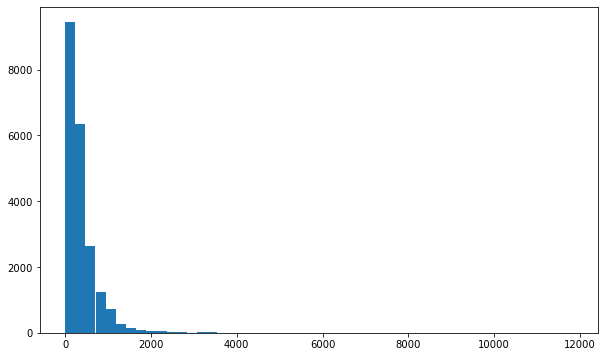

In [38]:
#To visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in clean_data.new_complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

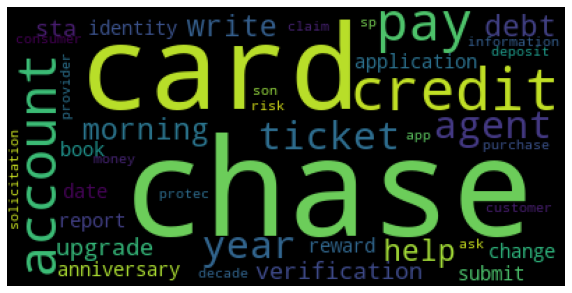

In [39]:
#find the top 40 words by frequency among all the articles after processing the text using word cloud
# !pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(clean_data.new_complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [41]:
#Removing -PRON- from the text corpus
clean_data['complaint_text_clean'] = clean_data['new_complaint_POS_removed'].str.replace('-PRON-', '')
clean_data = clean_data.drop(['new_complaint_POS_removed'],axis = 1)

In [42]:
#finding unigram,bigram,trigram frequency 
#To find the top 30 unigram,bigram,trigram frequency 

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]


In [43]:
top_30_unigrams = get_top_n_bigram(clean_data['complaint_text_clean'],ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(clean_data['complaint_text_clean'],ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(clean_data['complaint_text_clean'],ngram=3, top=30)

In [44]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', 55396),
 ('account', 39603),
 ('credit', 32425),
 ('card', 29043),
 ('payment', 20181),
 ('charge', 16501),
 ('time', 15214),
 ('money', 11665),
 ('day', 11643),
 ('bank', 11139)]

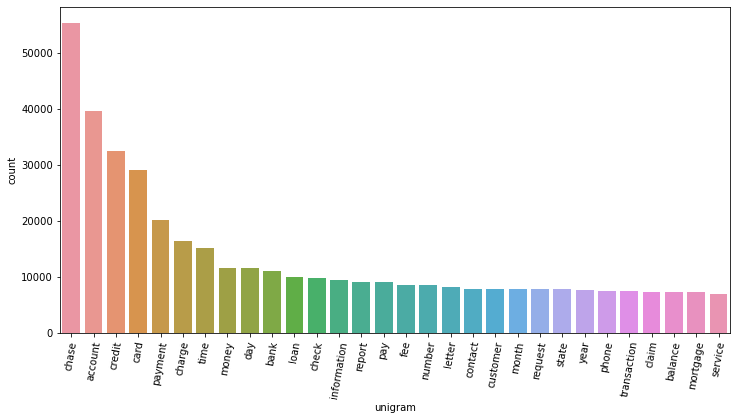

In [45]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [46]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', 12171),
 ('credit report', 3618),
 ('chase credit', 3135),
 ('customer service', 2714),
 ('account chase', 2657),
 ('chase account', 2181),
 ('contact chase', 1931),
 ('debit card', 1909),
 ('account account', 1837),
 ('chase bank', 1770)]

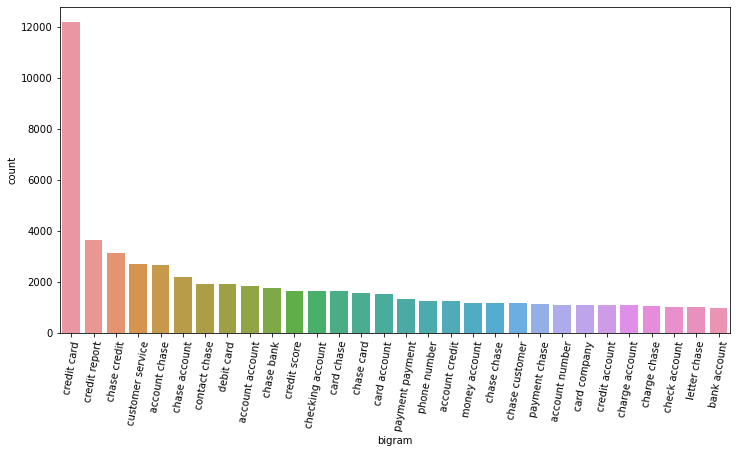

In [47]:
#Plot graph for the top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [48]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('chase credit card', 2159),
 ('credit card account', 986),
 ('credit card company', 958),
 ('credit card chase', 815),
 ('chase customer service', 509),
 ('charge credit card', 495),
 ('inquiry credit report', 456),
 ('credit card credit', 454),
 ('account credit card', 358),
 ('credit card charge', 356)]

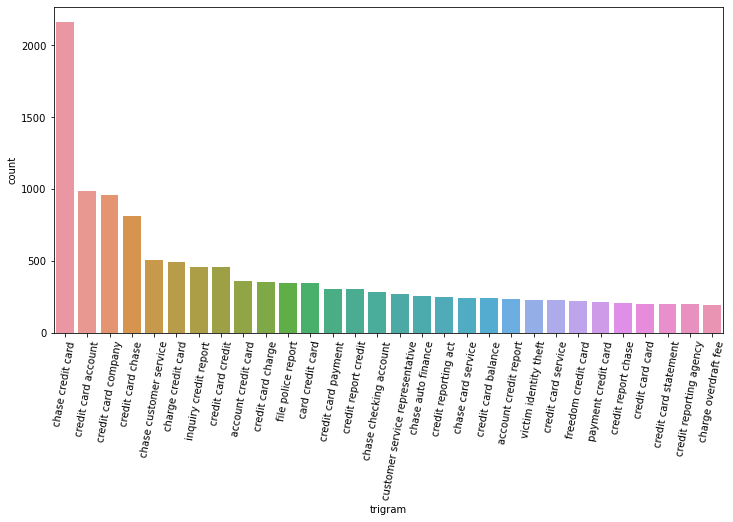

In [49]:
#Plot graph for the top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

In [50]:
# Remove xxx 
clean_data['complaint_text_clean'] = clean_data['complaint_text_clean'].str.replace('xxxx','')

## Feature extraction

In [93]:
#Write your code here to initialise the TfidfVectorizer 
tfi_df = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [94]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfi_df.fit_transform(clean_data['complaint_text_clean']) 
tfi_df.get_feature_names()[:10]
len(tfi_df.get_feature_names())

6116

## Topic Modelling

In [53]:
from sklearn.decomposition import NMF

In [95]:
#Load your nmf_model with the n_components i.e 5
no_topics =  5 

#keep the random_state =40
nmf_model = NMF(n_components=no_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [96]:

num_words=15

vocab = np.array(tfidf.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [97]:
vocab

array(['aarp', 'abate', 'abatement', ..., 'zip', 'zombie', 'zone'],
      dtype='<U107')

In [57]:
topics

['account check money chase deposit bank fund branch day transfer number checking transaction claim business',
 'credit card report inquiry chase score account company information debt limit application letter year remove',
 'payment balance pay month statement fee time day auto credit chase date mortgage year error',
 'charge fee card chase dispute transaction purchase merchant refund balance service claim overdraft pay time',
 'loan mortgage chase home modification property year document letter rate time request foreclosure sale information']

In [59]:
#Create the best topic

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(clean_data['complaint_text_clean']))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['top_topic_dominant'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,top_topic_dominant
Doc0,0.02,0.01,0.01,0.0,0.03,4
Doc1,0.01,0.00,0.00,0.0,0.01,0
Doc2,0.00,0.06,0.00,0.0,0.01,1
Doc3,0.02,0.06,0.00,0.0,0.02,1
Doc4,0.07,0.00,0.00,0.0,0.01,0


In [60]:
#Assign the best topic to each of the cmplaints in Topic Column
clean_data['Topic'] = significant_topic

In [61]:
pd.set_option('display.max_colwidth', -1)

In [62]:
clean_data[['text_complaint','complaint_text_clean','category','Topic']][clean_data.Topic==4].head(30)

text_complaint  \
1    good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [63]:
# 10 topics
temp_data =clean_data[['text_complaint','complaint_text_clean','category','Topic']].groupby('Topic').head(10)
temp_data.sort_values('Topic')

,text_complaint,complaint_text_clean,category,Topic
24,mishandling of this account by chase auto and xxxx,account chase auto,Vehicle loan or lease+Loan,0
43,chase sent me an email today with the innocuous title important information regarding changes to your chase account they often use similar titles for ads and other communications \n\nin it they force me into binding arbitration despite that never being something i had agreed to and never being a part of any contract between me and them \n\nthey do include a method to opt out but have no additional information about the consequences many other people ive seen who have had a similar problem are afraid that chase will close their account if they opt out and even more egregiously despite chase simply sending an email doing this they require me to mail them a letter with my personal information enclosed in order to opt out \n\nthis is clearly less secure and a massive loss of both my time and money that is clearly being used solely to dissuade people from opting out \n\nthis is blatant malpractice by chase,chase email today title information change chase account title ad communication force bind arbitration contract information consequence problem chase account opt chase email mail letter information order loss time money malpractice chase,Credit card or prepaid card+General-purpose credit card or charge card,0
42,my card went missing and i didnt realize it until today i checked my email and they said there has been deposits and money taken out again i had in my bank account and its gone,card today email deposit money bank account,Checking or savings account+Checking account,0
52,my roommate was stealing my chase debit card and drivers license pretending to be me and withdrawing money from my account he admitted that he figured out my pin because it happens to be the same as my phone password \n\nhe also admitted that he would sneak into my room while i was sleeping and put the card back before i woke up \n\nhe apologized but says he spent the money i tried to dispute this with chase but they claim that since my debit card pin number was used that they cant prove it wasnt me \n\nalthough they advertise that i have fraud protection they refuse to give me my money back \n\natm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx,steal chase debit card driver license money account admit figure pin phone password sneak room sleep card money dispute chase claim debit card pin number fraud protection money atm,Checking or savings account+Checking account,0
35,i opened the saving account for the bonus i was supposed to received the bonus after consecutive auto transfers from checking to savings i notice on that automatic transfer was cancelled for not enough funds into my checking s account therefore i put enough funds in my account on requested that the executive team reactivate my automatic transfer for the month of xxxx although ms xxxx reached out to me from the executive office she failed to try to resolve my concerns case xxxx,saving account bonus bonus auto transfer check saving notice transfer fund checking account fund account request team transfer month office fail resolve concern case,Checking or savings account+Savings account,0
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,term account deposit bonus pay day deposit account coupon code day bonus pay,Checking or savings account+Checking account,0
48,jp morgan chase bank please answer the following questions on xxxxxxxx xxxxxxxxxxxxxxxx xxxxxxxx xxxxxxxx jpmorgan chase accessed information abo

In [64]:
#Create the dictionary of Topic names and Topics Banking services, loans, Fraudalent reporting, Card, others.

topic_mapping = {
    0: 'Bank services',
    1: 'Cards',
    2: 'Others',
    3: 'Fraudalent reporting',
    4: 'Loan'
}
#Replace Topics with Topic Names
clean_data['Topic'] = clean_data['Topic'].map(topic_mapping)

In [66]:
clean_data.head()

,text_complaint,lemma,category,complaint_text_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection+Credit card debt,morning help write chase debt verification statement bank debt mail month attempt debt information consumer chase account advance help,Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card+General-purpose credit card or charge card,agent upgrade anniversary date change agent information order account agent mislead,Bank services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report application submit identity consent service credit identity applicant,Cards
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell chase representative speak application deny state ask information xxxx offer exp

<AxesSubplot:xlabel='Topic', ylabel='count'>

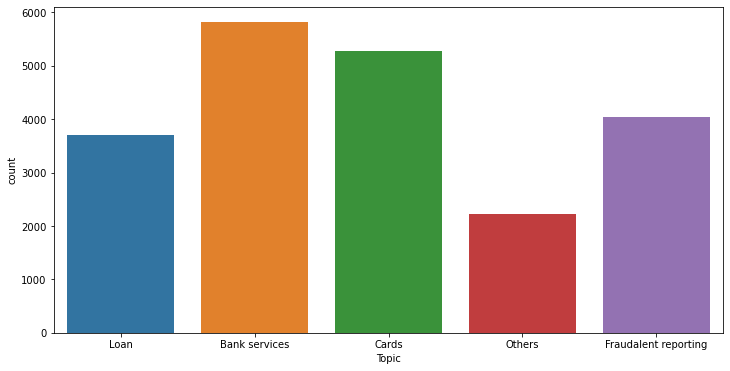

In [67]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=clean_data)

## Supervised modelling

In [70]:
training_data = clean_data[['text_complaint','Topic']]
training_data.head()

,text_complaint,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Bank services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Cards
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Cards
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Bank services


In [71]:
rev_topic_mapping = {
    'Bank services' :0,
    'Cards':1,
    'Others':2,
    'Fraudalent reporting':3,
    'Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(rev_topic_mapping)
training_data.head()

,text_complaint,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [72]:
training_data[['text_complaint','Topic']][training_data.Topic==2].head(30)

text_complaint  \
20   during the summer months i experience a decline income due to my employment therefore i request a one month payment extension with my auto loan company chase for the past almost fours years my request for payment extension is granted i have never been delinquent with my auto loan payment however on my request for a one month payment extension was denied this year i explained my situation to representative and the supervisor with no avail after a lengthy discussion and waiting i was informed the reason for the decline as it is not  contractual  this reason for denial baffled me and therefore i emailed the office of xxxx xxxx executive director communications jpmorgan chase  co a representative contacted me and stated chase will followup about week later a representative of xxxx xxxx xxxx xxxx office called the representative shared her role was help resolve the matter the representative via conference call contacted the department handing my request after reviewing my information my request was still denied based on  policy changes  i requested an explanation and representative stated a letter will be mailed with explanation i have received xxxx letters the reason for denial was not  policy changes  i would like cfpb help in exploring the denial of my payment extension request especially since i have been clear reason for denial                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [73]:
# creating vector count. Transform word vector to td-idf
# X - y  split

X = training_data.text_complaint
y = training_data.Topic

In [74]:
#code to get the Vector count,Fit transform the X
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [75]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [76]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

In [77]:
#models 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [78]:
# utlity function to display the model report

def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

In [79]:
# 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [80]:
#GridSearchCV object
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [98]:
# best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.94
Test Accuracy : 0.9
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      4362
           1       0.94      0.96      0.95      3955
           2       0.97      0.88      0.92      1672
           3       0.94      0.93      0.94      3031
           4       0.95      0.94      0.95      2784

    accuracy                           0.94     15804
   macro avg       0.95      0.93      0.94     15804
weighted avg       0.94      0.94      0.94     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1454
           1       0.90      0.93      0.91      1318
           2       0.95      0.80      0.87       558
           3       0.91      0.88      0.89      1010
           4       0.93      0.90      0.91       928

    accuracy              

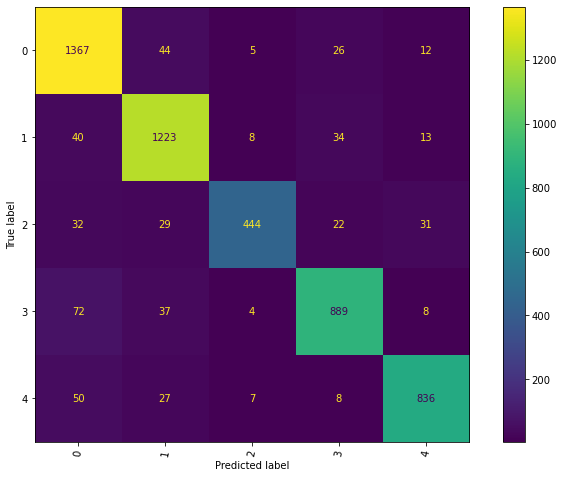

In [99]:
# Logistic Regression Classification
logistic_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
logistic_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(logistic_reg,metric2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9242597479567033
Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.99
Train Accuracy : 0.93
Test Accuracy : 0.93
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      4362
           1       0.93      0.95      0.94      3955
           2       0.94      0.92      0.93      1672
           3       0.93      0.92      0.92      3031
           4       0.95      0.93      0.94      2784

    accuracy                           0.93     15804
   macro avg       0.94      0.93      0.93     15804
weighted avg       0.93      0.93      0.93     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1454
           1       0.94      0.94      0.94      1318
           2       0.94    

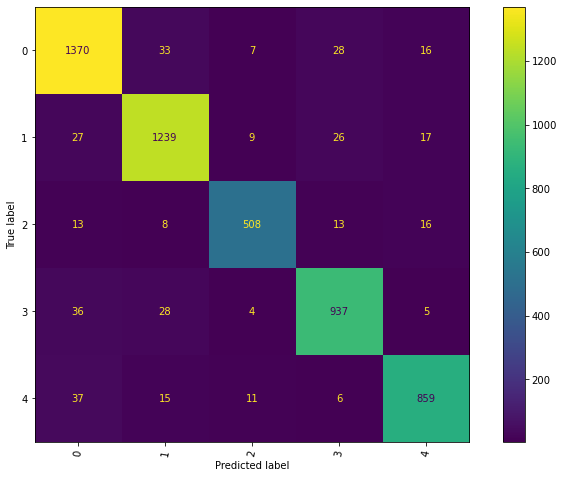

In [100]:
# Logistic Regression with GridSearchCV

# logistic regression
logistic_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(logistic_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric6=[]
display_classification_report(grid_search_log,metric6)

In [87]:
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ]
        }

log_metric = pd.Series(metric2, name = 'Logistic Regression')
grid_log_metric = pd.Series(metric6, name = 'Logistic Regression with GridSearchCV')

final_metric = pd.concat([log_metric,grid_log_metric], axis = 1)
final_metric

,Logistic Regression,Logistic Regression with GridSearchCV
0,1.00,0.99
1,0.99,0.99
2,0.94,0.93
3,0.90,0.93
4,0.94,0.93
5,0.90,0.93
6,0.94,0.93
7,0.90,0.93
8,0.94,0.93
9,0.90,0.93


In [88]:
# raw complaint text
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [89]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [90]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

array([0], dtype=int64)

In [91]:
topic_mapping[prediction[0]]

'Bank services'